# Introdução
Autor: Gustavo Shoiti Sonoda | RA: 217579


MAIS DETALHES NO GITHUB: https://github.com/GSSonoda/mo436_rl_carpole 

Neste trabalho da disciplina MO436A, o ambiente escolhido é o CartPole. 
A motivacao para a escolha dessa ambiente é que ele pode ser discretizado e possui um espaco de estados relativamente pequeno para o projeto apresentado. Além disso, já trabalhei com esse ambiente no meu TCC (2022) e disponho de uma planta física que poderá ser utilizada em futuros trabalhos.


### Definição do Problema
Este ambiente corresponde à versão do problema do carrinho e da vara descrita por **Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”**. Uma vara é fixada por uma junta não acionada a um carrinho, que se move ao longo de um trilho sem atrito. O pêndulo é colocado na vertical sobre o carrinho e o objetivo é equilibrar a vara aplicando forças na direção esquerda e direita sobre o carrinho.
 - Referencia: https://gymnasium.farama.org/environments/classic_control/cart_pole/

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from IPython.display import display, Markdown

from src.env.carpole_deterministic import CartPoleDeterministic
from src.env.carpole_stochastic import CartPoleStochastic
from src.env.carpole_continuos_stochastic import CartPoleContinuosStochastic
from src.env.carpole_continuos_deterministic import CartPoleContinuosDeterministic
from src.agents.monte_carlo import MonteCarloAgent
from src.agents.sarsa import SarsaLambdaAgent
from src.agents.q_learning import QLearningAgent
from src.agents.sarsa_lambda_fa import SarsaLambdaFA
from src.training.trainer_fa import TrainerFA

import inspect
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings


logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S",
)
logger = logging.getLogger("DRL-Baselines")

# Ambiente

### Formulação como MDP

#### Conjunto de Ações
A ação pode assumir os valores {0, 1} (discreto), indicando a direção da força com que o carrinho é empurrado.
- 0: Empurrar o carrinho para a esquerda
- 1: Empurrar o carrinho para a direita

#### Conjunto de Estados e Discretização

O ambiente CartPole apresenta um espaço de estados contínuo, composto por quatro variáveis principais. Na discretizacao, assumi um valor máximo absoluto de 5 para as velocidades (cart velocity e pole angular velocity) e dividi cada variável em 06 ou 12 bins. Essa discretização transforma os estados contínuos em uma tupla de quatro inteiros.

| Num | Observação            | Min      | Max     | Limite usado para discretização | Bins |
| --- | --------------------- | -------- | ------- | ------------------------------- | ---- |
| 0   | Cart Position         | -4.8     | 4.8     | -4.8 a 4.8                      | 06   |
| 1   | Cart Velocity         | -Inf     | Inf     | -5 a 5                          | 06   |
| 2   | Pole Angle            | ~ -0.418 | ~ 0.418 | -0.418 a 0.418                  | 12   |
| 3   | Pole Angular Velocity | -Inf     | Inf     | -5 a 5                          | 12   |


#### Função de Recompensa
Como o objetivo é manter a haste na vertical pelo maior tempo possível, por padrão, uma recompensa de +1 é concedida para cada passo dado, incluindo o passo de término. O limite de recompensa padrão é 500.

Se `sutton_barto_reward=True`, então uma recompensa de 0 é concedida para cada passo que não seja de término e -1 para o passo de término. Consequentemente, o limite de recompensa é 0.

#### Fim do Episodio
O ambiente CartPole é episódico. O episódio termina se ocorrer qualquer uma das seguintes situações:
 - Ângulo da barra ficar superior a ±12°
 - Posição do carrinho ficar superior a ±2,4 (o centro do carrinho atinge a borda da tela)
 - Duração do episódio superior a 500

### 4 Variações do CarPole

#### Deterministico Discretizado => env_dt
 - O valor de Random Number Generation (RNG) foi fixado
 - O estado inicial do ambiente, posicao e velocidade sao fixos em todos os espisodios

#### Deterministico Continuo => env_cont_dt
 - Igual ao Deterministico Discretizado só que com estados (s) continuos
 - As ações continuam sendo discretas

#### Estocástico Discretizado => env_stc
 - O valor de Random Number Generation (RNG) não é fixado. (comportamento padrão da biblioteca)
 - A condição inicial do ambiente, posicao e velocidade não são fixos, é atribuído um valor aleatório uniforme no intervalo (-0,05, 0,05).(comportamento padrão da biblioteca)
 - Um ruído gaussiano pequeno será adicionado à força aplicada no carrinho

#### Estocástico Continuo => env_cont_dt
 - Igual ao Estocástico Discretizado só que com estados (s) continuos
 - As ações continuam sendo discretas

In [2]:
# --- Parâmetros Ambiente ---
SEED = 10
N_STEPS = 50
N_EPISODES = 30
GAUSSIAN = 0.4
BINS = (6, 6, 12, 12)
STATES = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

In [3]:
env_dt = CartPoleDeterministic(seed=SEED, bins=BINS)
env_stc = CartPoleStochastic(force_std=GAUSSIAN, bins=BINS)
env_cont_stc = CartPoleContinuosStochastic(force_std=GAUSSIAN)
env_cont_dt = CartPoleContinuosDeterministic(seed=SEED)

In [4]:
N_ACTIONS = env_dt.action_space.n
N_STATES = tuple(env_dt.discretizer.bins)
print(f"N_ACTIONS: {N_ACTIONS} | N_STATES: {N_STATES} ")

N_ACTIONS: 2 | N_STATES: (6, 6, 12, 12) 


### Análise da Variancia: Determinístico vs Estocástico (Discreto)

In [5]:
states_dt = []  
states_stc = [] 
for ep in range(N_EPISODES):
    # determinístico
    obs, _ = env_dt.reset()
    ep_states_dt = [obs]
    for _ in range(N_STEPS-1):
        obs, _, done, truncated, _ = env_dt.step(0)
        ep_states_dt.append(obs)
    states_dt.append(ep_states_dt)
    # estocástico
    obs, _ = env_stc.reset()
    ep_states_stc = [obs]
    for _ in range(N_STEPS-1):
        obs, _, done, truncated, _ = env_stc.step(0)
        ep_states_stc.append(obs)
    states_stc.append(ep_states_stc)


states_dt = np.array(states_dt)      # shape (N_EPISODES, N_STEPS, 4)
states_stc = np.array(states_stc)
mean_dt = states_dt.mean(axis=0) # media determinístico
std_dt  = states_dt.std(axis=0) # veriancia determinístico
mean_stc = states_stc.mean(axis=0) # media estocástico
std_stc  = states_stc.std(axis=0) # veriancia estocástico

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


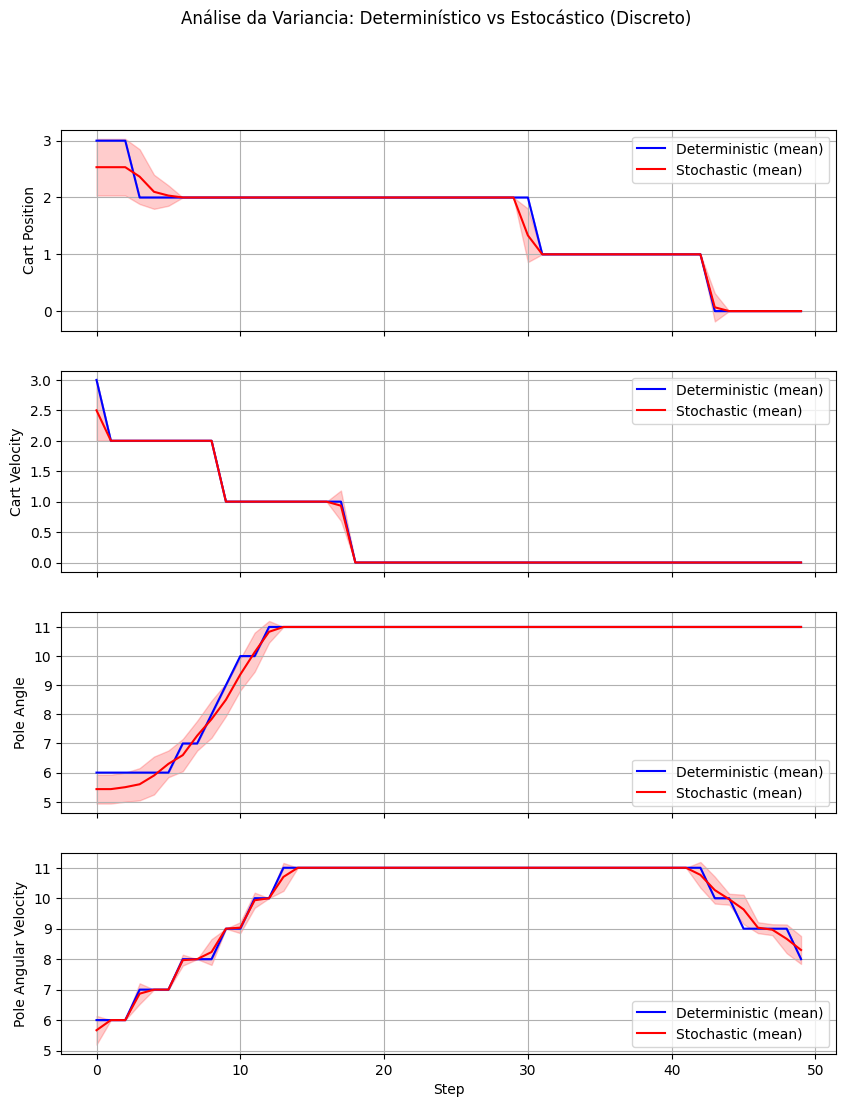

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for i, label in enumerate(STATES):
    axs[i].plot(mean_dt[:, i], label="Deterministic (mean)", color="blue")
    axs[i].fill_between(range(N_STEPS), mean_dt[:, i]-std_dt[:, i], mean_dt[:, i]+std_dt[:, i],
                        color="blue", alpha=0.2)
    
    axs[i].plot(mean_stc[:, i], label="Stochastic (mean)", color="red")
    axs[i].fill_between(range(N_STEPS), mean_stc[:, i]-std_stc[:, i], mean_stc[:, i]+std_stc[:, i],
                        color="red", alpha=0.2)
    
    axs[i].set_ylabel(label)
    axs[i].legend()
    axs[i].grid(True)

axs[3].set_xlabel("Step")
plt.suptitle("Análise da Variancia: Determinístico vs Estocástico (Discreto)")
plt.show()

# Agentes

## Monte Carlo

In [28]:
# Parâmetros MONTE CARLO
N0 = 100
GAMMA = 0.99

Classe Disponivel no GITHUB: https://github.com/GSSonoda/mo436_rl_carpole/blob/main/src/agents/monte_carlo.py

In [29]:
mc_dt = MonteCarloAgent(N_ACTIONS, n0=N0, gamma=GAMMA)
mc_stc = MonteCarloAgent(N_ACTIONS, n0=N0, gamma=GAMMA)

In [30]:
class MonteCarloTrainer:
    def __init__(self, agent, env, max_episodes=500, max_steps=500):
        self.agent = agent
        self.env = env
        self.max_episodes = max_episodes
        self.max_steps = max_steps

    def train(self):
        returns = []
        for ep in range(self.max_episodes):
            obs, _ = self.env.reset()
            episode = []
            total = 0.0
            for t in range(self.max_steps):
                a = self.agent.select_action(obs)
                out = self.env.step(a)
                if len(out) == 5:
                    obs2, r, terminated, truncated, _ = out
                    done = bool(terminated or truncated)
                else:
                    obs2, r, done, _ = out
                episode.append((obs, a, r))
                total += r
                obs = obs2
                if done:
                    break
            # Update expects episode list
            self.agent.update(episode)
            returns.append(total)
        return returns

## Q-Learning

In [31]:
# Parâmetros Q-Learning
GAMMA = 0.99
N0 = 100

Classe Disponivel no GITHUB: https://github.com/GSSonoda/mo436_rl_carpole/blob/main/src/agents/q_learning.py

In [33]:
# Mais detalhes em: https://github.com/GSSonoda/mo436_rl_carpole/blob/main/src/agents/q_learning.py
qlearning_dt = QLearningAgent(N_STATES, N_ACTIONS, gamma=GAMMA, n0=N0)
qlearning_stc = QLearningAgent(N_STATES, N_ACTIONS, gamma=GAMMA, n0=N0)

In [34]:
class QLearningTrainer:
    def __init__(self, agent, env, max_episodes=1000, max_steps=500):
        self.agent = agent
        self.env = env
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        # decide whether agent.update is online or episodic
        self.episodic = is_episode_based(agent)

    def train(self):
        returns = []
        for ep in range(self.max_episodes):
            obs, _ = self.env.reset()
            total = 0.0
            episode = []
            for t in range(self.max_steps):
                a = self.agent.select_action(obs)
                out = self.env.step(a)
                if len(out) == 5:
                    obs2, r, terminated, truncated, _ = out
                    done = bool(terminated or truncated)
                else:
                    obs2, r, done, _ = out
                total += r
                if self.episodic:
                    episode.append((obs, a, r))
                else:
                    # online update signature: update(s,a,r,s',done)
                    try:
                        self.agent.update(obs, a, r, obs2, done)
                    except TypeError:
                        # Try common variant with next_action param (Q usually doesn't use next_action)
                        try:
                            self.agent.update(obs, a, r, obs2)
                        except Exception as e:
                            warnings.warn(f"Agent.update failed online call: {e}; will collect episodic and try episodic update.")
                            episode.append((obs, a, r))
                obs = obs2
                if done:
                    break
            if self.episodic and len(episode) > 0:
                self.agent.update(episode)
            returns.append(total)
        return returns

## SARSA Tabular

In [35]:
# Parâmetros SARSA
GAMMA = 0.99
N0 = 100
LAM = 0.8

Classe Disponivel no GITHUB: https://github.com/GSSonoda/mo436_rl_carpole/blob/main/src/agents/sarsa.py

In [37]:
sarsa_dt = SarsaLambdaAgent(N_ACTIONS, gamma=GAMMA, N0=N0, lam=LAM)
sarsa_stc = SarsaLambdaAgent(N_ACTIONS, gamma=GAMMA, N0=N0, lam=LAM)

In [38]:
class SarsaTabularTrainer:
    def __init__(self, agent, env, max_episodes=1000, max_steps=500):
        self.agent = agent
        self.env = env
        self.max_episodes = max_episodes
        self.max_steps = max_steps
        self.episodic = is_episode_based(agent)

    def train(self):
        returns = []
        for ep in range(self.max_episodes):
            obs, _ = self.env.reset()
            a = self.agent.select_action(obs)
            total = 0.0
            episode = []
            for t in range(self.max_steps):
                out = self.env.step(a)
                if len(out) == 5:
                    obs2, r, terminated, truncated, _ = out
                    done = bool(terminated or truncated)
                else:
                    obs2, r, done, _ = out
                total += r
                if self.episodic:
                    episode.append((obs, a, r))
                else:
                    a2 = self.agent.select_action(obs2)
                    try:
                        self.agent.update(obs, a, r, obs2, a2, done)
                    except TypeError:
                        # fallback
                        episode.append((obs, a, r))
                    a = a2
                obs = obs2
                if done:
                    break
            if self.episodic and len(episode) > 0:
                self.agent.update(episode)
            returns.append(total)
        return returns

## Sarsa Linear Approximator

In [39]:
# Parâmetros SARSA LINEAR Approximator
N_FEATURES = 4
ALPHA = 0.03
GAMMA = 0.99
LAM = 0.8
EPSILON = 0.05

In [17]:
sarsa_fa_dt = SarsaLambdaFA(
    n_actions=N_ACTIONS,
    n_features=N_FEATURES,
    alpha=ALPHA,
    gamma=GAMMA,
    lam=LAM,
    epsilon=EPSILON
)
sarsa_fa_stc = SarsaLambdaFA(
    n_actions=N_ACTIONS,
    n_features=N_FEATURES,
    alpha=ALPHA,
    gamma=GAMMA,
    lam=LAM,
    epsilon=EPSILON
)

In [18]:
class SarsaFATrainer:
    def __init__(self, agent, env, max_episodes=2000, max_steps=500):
        self.agent = agent
        self.env = env
        self.max_episodes = max_episodes
        self.max_steps = max_steps

    def train(self):
        returns = []
        for ep in range(self.max_episodes):
            obs, _ = self.env.reset()
            # ensure agent has traces reset if it supports it
            if hasattr(self.agent, "reset_traces"):
                try:
                    self.agent.reset_traces()
                except Exception:
                    pass
            a = self.agent.select_action(obs)
            total = 0.0
            for t in range(self.max_steps):
                out = self.env.step(a)
                if len(out) == 5:
                    obs2, r, terminated, truncated, _ = out
                    done = bool(terminated or truncated)
                else:
                    obs2, r, done, _ = out
                a2 = self.agent.select_action(obs2)
                # expect online update signature for FA:
                self.agent.update(obs, a, r, obs2, a2, done)
                total += r
                obs, a = obs2, a2
                if done:
                    break
            returns.append(total)
        return returns

# TRAINING

In [19]:
def is_episode_based(agent):
    """Detecta se agent.update aceita 1 argumento (episode) ou vários (online).
    Retorna True se parece ser episódico (update(episode))."""
    try:
        sig = inspect.signature(agent.update)
        params = list(sig.parameters.values())
        if len(params) == 1:
            return True
        # if var positional or >1, assume online
        return False
    except (AttributeError, ValueError):
        # se não encontrarmos assinatura, tente chamar com episódio mais tarde
        return True

def run_eval_episode(env, agent, max_steps=200, deterministic=True):
    """Roda 1 episódio sem alterar estado do agente (usa select_action apenas)."""
    state, _ = env.reset()
    total = 0.0
    for t in range(max_steps):
        action = agent.select_action(state)
        out = env.step(action)
        if len(out) == 5:
            state, r, terminated, truncated, _ = out
            done = bool(terminated or truncated)
        else:
            state, r, done, _ = out
        total += r
        if done:
            break
    return float(total)

In [20]:
grid = [
    # (label, trainer_class, agent_instance, env_instance, episodes, max_steps)
    # Monte Carlo -> discrete only
    ("MC_dt", MonteCarloTrainer, mc_dt, env_dt, 2000, 1000),
    ("MC_stc", MonteCarloTrainer, mc_stc, env_stc, 2000, 1000),
    # Q-learning (tabular) -> discrete only
    ("Q_dt", QLearningTrainer, qlearning_dt, env_dt, 2000, 1000),
    ("Q_stc", QLearningTrainer, qlearning_stc, env_stc, 2000, 1000),
    # SARSA tabular -> discrete
    ("SARSA_dt", SarsaTabularTrainer, sarsa_dt, env_dt, 2000, 1000),
    ("SARSA_stc", SarsaTabularTrainer, sarsa_stc, env_stc, 2000, 1000),
    # SARSA with function approximation -> continuous envs only
    ("SARSA_FA_dt", SarsaFATrainer, sarsa_fa_dt, env_cont_dt, 2000, 1000),
    ("SARSA_FA_stc", SarsaFATrainer, sarsa_fa_stc, env_cont_stc, 2000, 1000),
]

In [21]:
results = {}
for label, TrainerCls, agent, env, episodes, max_steps in grid:
    print(f"Training {label} ({TrainerCls.__name__}) on env {env.__class__.__name__} for {episodes} episodes...")
    trainer = TrainerCls(agent, env, max_episodes=episodes, max_steps=max_steps)
    rewards = trainer.train()
    results[label] = rewards
    print(f" -> done. Last return: {rewards[-1] if len(rewards)>0 else None}")

Training MC_dt (MonteCarloTrainer) on env CartPoleDeterministic for 2000 episodes...
 -> done. Last return: 214.0
Training MC_stc (MonteCarloTrainer) on env CartPoleStochastic for 2000 episodes...
 -> done. Last return: 169.0
Training Q_dt (QLearningTrainer) on env CartPoleDeterministic for 2000 episodes...
 -> done. Last return: 65.0
Training Q_stc (QLearningTrainer) on env CartPoleStochastic for 2000 episodes...
 -> done. Last return: 142.0
Training SARSA_dt (SarsaTabularTrainer) on env CartPoleDeterministic for 2000 episodes...
 -> done. Last return: 10.0
Training SARSA_stc (SarsaTabularTrainer) on env CartPoleStochastic for 2000 episodes...
 -> done. Last return: 10.0
Training SARSA_FA_dt (SarsaFATrainer) on env CartPoleContinuosDeterministic for 2000 episodes...
 -> done. Last return: -1.0
Training SARSA_FA_stc (SarsaFATrainer) on env CartPoleContinuosStochastic for 2000 episodes...
 -> done. Last return: 30.0


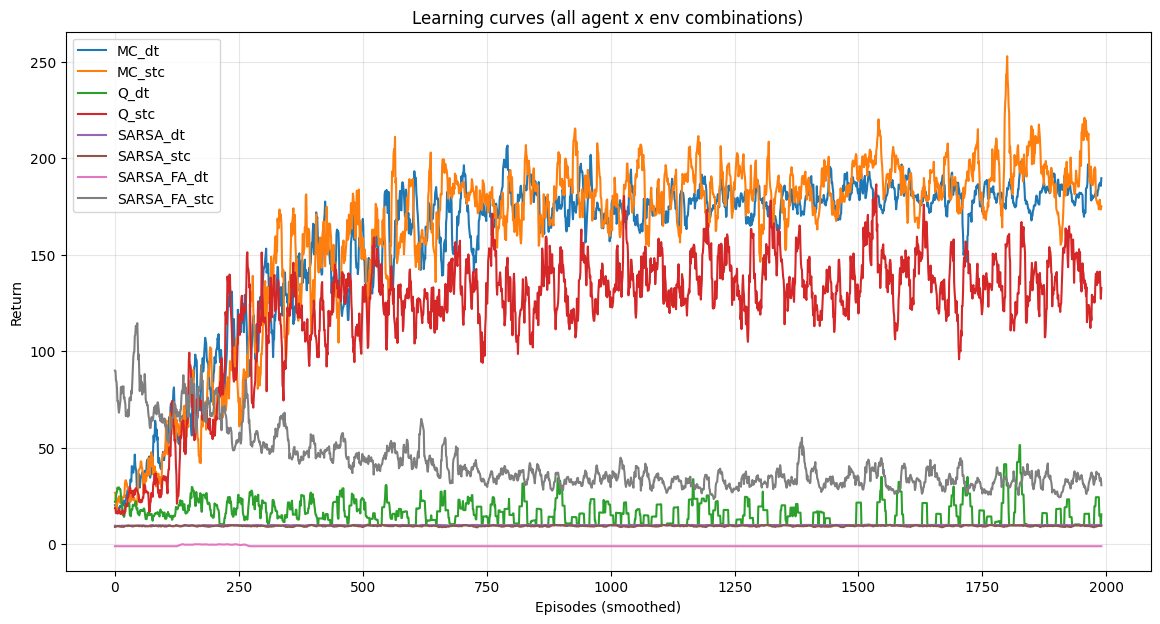

In [22]:
plt.figure(figsize=(14,7))
for label, rewards in results.items():
    smooth = np.convolve(rewards, np.ones(10)/10, mode='valid') if len(rewards)>=10 else rewards
    plt.plot(smooth, label=label)
plt.xlabel("Episodes (smoothed)")
plt.ylabel("Return")
plt.legend()
plt.title("Learning curves (all agent x env combinations)")
plt.grid(alpha=0.3)
plt.show()

# AVALIAÇÃO

Os experimentos foram realizados com quatro agentes (Monte Carlo, Q-Learning, SARSA e SARSA com Aproximação Linear de Funções), avaliados nos ambientes determinístico e estocástico do CartPole. Os hiperparâmetros utilizados foram conservadores, todos com γ = 0.99, N0 = 100, λ = 0.8 (para SARSA e SARSA(λ)), e no caso do aproximador linear, α = 0.03 e ε = 0.05.

In [23]:
agents_to_eval = {}
for label, TrainerCls, agent, env, episodes, max_steps in grid:
    agents_to_eval[label] = agent

def evaluate_agents(agents, num_episodes=10, deterministic=True, max_steps=1000):
    results_eval = {}
    for name, agent in agents.items():
        env = None
        for lab, _, a, e, _, _ in grid:
            if lab == name:
                env = e
                break
        if env is None:
            continue
        ep_returns = []
        for _ in range(num_episodes):
            R = run_eval_episode(env, agent, max_steps=max_steps, deterministic=deterministic)
            ep_returns.append(R)
        arr = np.array(ep_returns, dtype=np.float32)
        results_eval[name] = {"returns": arr, "mean": float(arr.mean()), "std": float(arr.std())}
        print(f"[EVAL] {name}: mean={arr.mean():.2f} std={arr.std():.2f}")
    return results_eval

eval_results = evaluate_agents(agents_to_eval, num_episodes=10, deterministic=True, max_steps=500)

[EVAL] MC_dt: mean=187.00 std=10.57
[EVAL] MC_stc: mean=191.10 std=26.17
[EVAL] Q_dt: mean=10.00 std=0.00
[EVAL] Q_stc: mean=131.10 std=39.44
[EVAL] SARSA_dt: mean=10.20 std=0.75
[EVAL] SARSA_stc: mean=50.80 std=25.27
[EVAL] SARSA_FA_dt: mean=-1.00 std=0.00
[EVAL] SARSA_FA_stc: mean=33.30 std=11.93


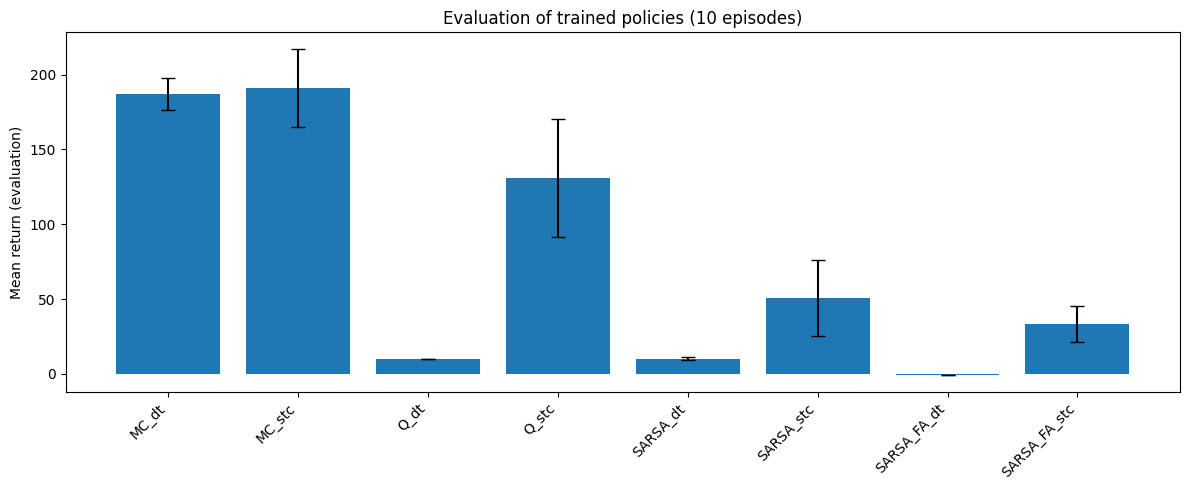

In [24]:
labels = list(eval_results.keys())
means = [eval_results[k]['mean'] for k in labels]
stds = [eval_results[k]['std'] for k in labels]

plt.figure(figsize=(12,5))
x = np.arange(len(labels))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Mean return (evaluation)')
plt.title('Evaluation of trained policies (10 episodes)')
plt.tight_layout()
plt.show()

### Desempenho Observado
#### Monte Carlo

O Monte Carlo apresentou o melhor desempenho em ambos os ambientes. Isto é coerente com sua natureza baseada em retorno completo, que evita problemas de instabilidade presentes em métodos bootstrapped. Com a recompensa do CartPole sendo proporcional ao tempo de sobrevivência, o método encaixa-se particularmente bem e converge de maneira robusta.

#### Q-Learning

O Q-Learning obteve desempenho ruim no ambiente determinístico, convergindo para uma política instável (≈10 passos). Isso é consistente com problemas conhecidos de aprendizado com estado discretizado em ambientes determinísticos, onde ações subótimas podem ser reforçadas precocemente. Curiosamente, no ambiente estocástico, o ruído induziu maior exploração, levando a resultados significativamente melhores (≈130).

#### SARSA

O SARSA apresentou desempenho semelhante ao Q-Learning no cenário determinístico (≈10) e desempenho moderadamente melhor no estocástico (≈50). Isso indica que, embora mais estável que Q-Learning, o SARSA ainda sofre bastante com discretização limitada e escolhas de hiperparâmetros.

#### SARSA com Aproximação Linear (FA)

A pior performance foi observada no SARSA com função linear, especialmente no ambiente determinístico (retorno negativo). Isso já era esperado, pois o CartPole é um problema intrinsicamente não-linear, enquanto o modelo linear com apenas 4 features é incapaz de representar adequadamente as fronteiras de decisão necessárias para o controle.